# Интеллектуальный анализ данных – весна 2024
# Домашнее задание 6: классификация текстов

Правила:



*   Домашнее задание оценивается в 10 баллов.
*   Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.
*  Можно использовать любые свободные источники с *обязательным* указанием ссылки на них.
*  Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.
*  Старайтесь сделать код как можно более оптимальным. В частности, будет штрафоваться использование циклов в тех случаях, когда операцию можно совершить при помощи инструментов библиотек, о которых рассказывалось в курсе.

В этом домашнем задании вам предстоит построить классификатор текстов.

Будем предсказывать эмоциональную окраску твиттов о коронавирусе.



In [401]:
import numpy as np
import pandas as pd
from typing import List, Dict
import matplotlib.pyplot as plt
import seaborn as sns
from string import punctuation

In [402]:
import os
if not os.path.exists('/content/tweets_coronavirus.csv'):
    if not os.path.exists("/content"):
        os.mkdir("/content")

    import requests
    # Download dataset
    url = r"https://github.com/i80287/iad-intro-ds/raw/master/2024/homeworks/hw06_texts/tweets_coronavirus.csv"
    r = requests.get(url)
    assert r.ok

    with open("/content/tweets_coronavirus.csv", "w") as f:
        f.write(r.content.decode())


In [403]:
df = pd.read_csv('/content/tweets_coronavirus.csv', encoding='latin-1')
df.sample(4)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
23209,32154,77106,"Scotland, United Kingdom",04-04-2020,Just back from work where we care for the most...,Positive
26595,36383,81335,NaN,07-04-2020,"For all the #VegetableOils markets, the essent...",Positive
28346,38564,83516,"Texas Medical Center, Houston",08-04-2020,It s important to be diligent when leaving you...,Positive
1774,5960,50912,Singapore,17-03-2020,"Dear Singaporeans, we have supplies, please do...",Positive


Для каждого твитта указано:


*   UserName - имя пользователя, заменено на целое число для анонимности
*   ScreenName - отображающееся имя пользователя, заменено на целое число для анонимности
*   Location - местоположение
*   TweetAt - дата создания твитта
*   OriginalTweet - текст твитта
*   Sentiment - эмоциональная окраска твитта (целевая переменная)



## Задание 1 Подготовка (0.5 балла)

Целевая переменная находится в колонке `Sentiment`.  Преобразуйте ее таким образом, чтобы она стала бинарной: 1 - если у твитта положительная эмоциональная окраска и 0 - если отрицательная.

In [404]:
df["Sentiment"].unique()

array(['Positive', 'Extremely Negative', 'Negative', 'Extremely Positive'],
      dtype=object)

In [405]:
df["Sentiment"] = (df["Sentiment"] == "Positive") | (df["Sentiment"] == "Extremely Positive")

Сбалансированы ли классы?

In [406]:
df["Sentiment"].value_counts()

Sentiment
True     18046
False    15398
Name: count, dtype: int64

**Ответ:** Классы получились достаточно сбалансированными

Выведете на экран информацию о пропусках в данных. Если пропуски присутствуют заполните их строкой 'Unknown'.

In [407]:
df.isna().sum()

UserName            0
ScreenName          0
Location         7049
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64

7049 пропусков в Location

In [408]:
df.fillna("Unknown", inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33444 entries, 0 to 33443
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       33444 non-null  int64 
 1   ScreenName     33444 non-null  int64 
 2   Location       33444 non-null  object
 3   TweetAt        33444 non-null  object
 4   OriginalTweet  33444 non-null  object
 5   Sentiment      33444 non-null  bool  
dtypes: bool(1), int64(2), object(3)
memory usage: 1.3+ MB


Разделите данные на обучающие и тестовые в соотношении 7 : 3 и `random_state=0`

In [409]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, random_state=0, test_size=0.3)

In [410]:
train.shape, test.shape

((23410, 6), (10034, 6))

## Задание 2 Токенизация (3 балла)

Постройте словарь на основе обучающей выборки и посчитайте количество встреч каждого токена с использованием самой простой токенизации - деления текстов по пробельным символам и приведение токенов в нижний регистр

In [411]:
merged_text: str = '\n'.join(df["OriginalTweet"].apply(lambda tw: tw.lower()))
all_tokens: List[str] = merged_text.split()

def make_token_popularity_dict(tokens: List[str]) -> Dict[str, int]:
    d = {tok: 0 for tok in tokens}
    for tok in tokens:
        d[tok] += 1
    return d

tokens_dict = make_token_popularity_dict(all_tokens)

Какой размер словаря получился?

In [412]:
len(tokens_dict)

103200

Выведите 10 самых популярных токенов с количеством встреч каждого из них. Объясните, почему именно эти токены в топе

In [413]:
def print_top_n_popular_tokens(d: Dict[str, int], n: int = 10):
    pairs = sorted(d.items(), key=lambda pair: pair[1], reverse=True)
    print(f"Top {n} popular tokens:")
    print('\n'.join(f"{word}: {freq}" for word, freq in pairs[:n]))

print_top_n_popular_tokens(tokens_dict)

Top 10 popular tokens:
the: 38250
to: 33447
and: 20935
of: 18578
a: 16667
in: 16024
for: 12193
#coronavirus: 11759
is: 10596
are: 9958


**Ответ:** слова the, to, and, of, a, in, for, is, are - служебные слова, которые встречаются чаще других слов, т.к. не относятся к конкретной теме, а обязательно присутствуют почти в любом предложении. Слово (в данном случае - тег из твитов) #coronavirus часто встречается в твитах, т.к. их тематика - коронавирус (по аналогии с примером с семинара - в отзывах на банк часто будет встречаться слово 'банк')

Удалите стоп-слова из словаря и выведите новый топ-10 токенов (и количество встреч) по популярности.  Что можно сказать  о нем?

In [414]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

for stop_word in stopwords.words():
    tokens_dict.pop(stop_word, None)

print_top_n_popular_tokens(tokens_dict)

Top 10 popular tokens:
#coronavirus: 11759
prices: 5625
food: 5409
grocery: 4882
supermarket: 4662
covid-19: 4504
store: 4486
#covid19: 3561
consumer: 3233
&amp;: 3191


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Владимир\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**Ответ:** тег #coronavirus остался, т.к. не является стоп-словом, а также среди топа самых популярных токенов появился новый - #covid19 (причина такая же, как и у токена #coronavirus). Также есть выражение &amp. Остальные слова связаны с едой, супермаркетами, ценами и потреблением. Возможно, это связано с тем, что во время эпидемии ковида была затруднена покупка продуктов в физическом магазине и люди постили твиты об обредшем большую популярность способе заказа продуктов онлайн с доставкой

Также выведите 20 самых непопулярных слов (если самых непопулярных слов больше выведите любые 20 из них) Почему эти токены непопулярны, требуется ли как-то дополнительно работать с ними?

In [415]:
def print_top_n_unpopular_tokens(d: dict, n: int = 20):
    pairs = sorted(d.items(), key=lambda pair: pair[1], reverse=False)
    print(f"Top {n} unpopular tokens:")
    print('\n'.join(f"{word}: {freq}" for word, freq in pairs[:n]))
    
print_top_n_unpopular_tokens(tokens_dict)

Top 20 unpopular tokens:
poss: 1
australia:: 1
https://t.co/binca9vp8p: 1
#confinementgeneral: 1
https://t.co/zrlg0z520j: 1
litteraly: 1
#coronavirusfrance: 1
https://t.co/usmualq72n: 1
@tim_dodson: 1
https://t.co/cfxch7a2lu: 1
civics: 1
about".: 1
https://t.co/iefdnehgdo: 1
https://t.co/kw91zj5o5i: 1
prevention,we: 1
19?.: 1
#govindia: 1
#horningsea: 1
https://t.co/lsgrxxhjhh: 1
https://t.co/8ywakfjexc: 1


**Ответ:** самые непопулярные токены содержат символы #@:? (например, никнеймы, теги, ссылки, числа со знаками, разделяющими дробную часть и разряды, точки в конце предложения, слова, разделённые только запятой, без пробела). Возможно, имеет смысл удалить точки после слов, стоящих в конце предложения и отдельно обрабатывать ссылки



Теперь воспользуемся токенайзером получше - TweetTokenizer из библиотеки nltk. Примените его и посмотрите на топ-10 популярных слов. Чем он отличается от топа, который получался раньше? Почему?

In [416]:
from nltk.tokenize import TweetTokenizer

new_dict = make_token_popularity_dict(TweetTokenizer().tokenize(merged_text))
print_top_n_popular_tokens(new_dict)

Top 10 popular tokens:
the: 38499
.: 34264
to: 33588
,: 25142
and: 21134
of: 18622
a: 16863
in: 16232
?: 13730
#coronavirus: 12587


**Ответ:** Токенайзер по умолчанию не удяляет стоп-слова и пункуацию, а они встречаются в твитах достаточно часто

Удалите из словаря стоп-слова и пунктуацию, посмотрите на новый топ-10 слов с количеством встреч, есть ли теперь в нем что-то не похожее на слова?

In [417]:
from string import punctuation

for stop_word_or_punc in (stopwords.words() + list(punctuation)):
    new_dict.pop(stop_word_or_punc, None)

print_top_n_popular_tokens(new_dict)

Top 10 popular tokens:
#coronavirus: 12587
â: 10498
: 10361
19: 10142
covid: 8832
prices: 6644
food: 6213
: 6190
store: 5494
supermarket: 5435


**Ответ:** токенайзер отделил 19 отдельно от тега (встречается часто, т.к. это год эпидемии), а также количество тегов #coronavirus теперь 12587 (11759 из них - от тега #coronavirus19). Также, появилось несколько дополнительных символов из части таблицы Unicode, которые не попадают в стандартную таблицу ascii (ord(c) <= 127)

Удалите из словаря токены из одного символа, с позицией в таблице Unicode 128 и более (`ord(x) >= 128`)

Выведите топ-10 самых популярных и топ-20 непопулярных слов. Чем полученные топы отличаются от итоговых топов, полученных при использовании токенизации по пробелам? Что теперь лучше, а что хуже?

In [418]:
new_dict = dict(filter(lambda token_with_freq: len(token_with_freq[0]) != 1 or ord(token_with_freq[0]) < 128, new_dict.items()))

print_top_n_popular_tokens(new_dict)
print()
print_top_n_unpopular_tokens(new_dict)

Top 10 popular tokens:
#coronavirus: 12587
19: 10142
covid: 8832
prices: 6644
food: 6213
store: 5494
supermarket: 5435
grocery: 4959
#covid19: 3726
consumer: 3367

Top 20 unpopular tokens:
poss: 1
https://t.co/binca9vp8p: 1
#confinementgeneral: 1
https://t.co/zrlg0z520j: 1
litteraly: 1
#coronavirusfrance: 1
https://t.co/usmualq72n: 1
@tim_dodson: 1
https://t.co/cfxch7a2lu: 1
civics: 1
https://t.co/iefdnehgdo: 1
https://t.co/kw91zj5o5i: 1
#govindia: 1
#horningsea: 1
https://t.co/lsgrxxhjhh: 1
https://t.co/8ywakfjexc: 1
adara: 1
https://t.co/pna797jdkv: 1
https://t.co/dqox6usihz: 1
https://t.co/9idzsis5oq: 1


**Ответ:** # результаты идентичны, однако в данном случае в топ попало число 19, которое в данном случае не будет полезно (т.к. твиты на тему коронавируса 2019 года)

Выведите топ-10 популярных хештегов с количеством встреч. Что можно сказать о них?

In [419]:
def print_top_n_popular_hashtags(d: Dict[str, int], n: int = 10):
    hashtags_with_freq = [token_with_freq for token_with_freq in d.items() if token_with_freq[0][0] == '#']
    hashtags_with_freq.sort(key=lambda pair: pair[1], reverse=True)
    n = min(n, len(hashtags_with_freq))
    print(f"Top {n} popular hashtags:")
    print('\n'.join(f"{word}: {freq}" for word, freq in hashtags_with_freq[:n]))

print_top_n_popular_hashtags(new_dict)

Top 10 popular hashtags:
#coronavirus: 12587
#covid19: 3726
#covid_19: 2525
#covid2019: 1370
#toiletpaper: 1070
#covid: 919
#socialdistancing: 701
#coronacrisis: 627
#pandemic: 359
#coronaviruspandemic: 344


**Ответ:** почти все хештеги явно указывают на эпидемию коронавируса, а те, что не указывают явно, описывают затруднения, вызванные эпидемией (например, #toiletpaper и #socialdistancing)

То же самое проделайте для ссылок на сайт https://t.co Сравнима ли популярность ссылок с популярностью хештегов? Будет ли информация о ссылке на конкретную страницу полезна?

In [420]:
def print_top_n_popular_links(d: Dict[str, int], link_prefix: str = "https://t.co", n: int = 10):
    assert isinstance(link_prefix, str) and link_prefix

    links_with_freq = [token_with_freq for token_with_freq in d.items() if token_with_freq[0].startswith(link_prefix)]
    links_with_freq.sort(key=lambda pair: pair[1], reverse=True)
    n = min(n, len(links_with_freq))
    print(f"Top {n} popular links with prefix {link_prefix}:")
    print('\n'.join(f"{word}: {freq}" for word, freq in links_with_freq[:n]))

print_top_n_popular_links(new_dict)

Top 10 popular links with prefix https://t.co:
https://t.co/oxa7swtond: 6
https://t.co/g63rp042ho: 5
https://t.co/r7sagojsjg: 4
https://t.co/wrlhyzizaa: 4
https://t.co/ymsemlvttd: 4
https://t.co/3kfuiojxep: 4
https://t.co/oi39zsanq8: 4
https://t.co/6yvykiab2c: 4
https://t.co/xpcm2xkj4o: 4
https://t.co/gu6b4xpqp4: 4


**Ответ:** сама по себе ссылка как терм в тексте не несёт полезной информации, однако, если указывает на валидный ресурс, может быть использована для дополнительного изучения тематики текстов (формально, это не входит в решаемую задачу классификации отзыва как последовательность слов)

Используем опыт предыдущих экспериментов и напишем собственный токенайзер, улучшив TweetTokenizer. Функция tokenize должна:



*   Привести текст в нижний регистр
*   Применить TweetTokenizer для изначального выделения токенов
*   Удалить стоп-слова, пунктуацию, токены из одного символа, с позицией в таблице Unicode 128 и более и ссылки на t.co



In [421]:
BANNED_TOKENS = set(stopwords.words("english")) | set(punctuation)

def custom_tokenizer(text: str) -> List[str]:
    return [
        token for token in TweetTokenizer().tokenize(text.lower())
            if token not in BANNED_TOKENS \
                and not token.startswith("https://t.co") \
                    and not (len(token) == 1 and ord(token) >= 128)
    ]


In [422]:
custom_tokenizer('This is sample text!!!! @Sample_text I, \x92\x92 https://t.co/sample  #sampletext')

['sample', 'text', '@sample_text', '#sampletext']

## Задание 3 Векторизация текстов (2 балла)

Обучите CountVectorizer с использованием custom_tokenizer в качестве токенайзера. Как размер полученного словаря соотносится с размером изначального словаря из начала задания 2?

In [423]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(tokenizer=custom_tokenizer).fit(train.OriginalTweet)
print(len(cv.vocabulary_))

e:\Programs\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


45308


**Ответ:** размер словаря уменьшился более, чем в 2 раза (103200 -> 44517) (примерно в 2.31822 раза)

Посмотрим на какой-нибудь конкретный твитт:

In [424]:
ind = 9023
train.iloc[ind]['OriginalTweet'], train.iloc[ind]['Sentiment']

('Nice one @SkyNews lets not panic but show ppl in france queueing for food!!! #CoronavirusOutbreak #COVID2019 brainless!! Ffs',
 False)

Автор твитта не доволен ситуацией с едой во Франции и текст имеет резко негативную окраску.

Примените обученный CountVectorizer для векторизации данного текста, и попытайтесь определить самый важный токен и самый неважный токен (токен, компонента которого в векторе максимальна/минимальна, без учета 0). Хорошо ли они определились, почему?

In [425]:
vec = cv.transform([train.iloc[ind]['OriginalTweet']])
vec

<1x45308 sparse matrix of type '<class 'numpy.int64'>'
	with 14 stored elements in Compressed Sparse Row format>

In [426]:
indices = vec.nonzero()
pd.DataFrame(np.array(vec[indices]), columns=cv.get_feature_names_out()[indices[1]])

,#coronavirusoutbreak,#covid2019,@skynews,brainless,ffs,food,france,lets,nice,one,panic,ppl,queueing,show
0,1,1,1,1,1,1,1,1,1,1,1,1,1,1


**Ответ:** # У всех слов из текста ненулевые компоненты вектора равны 1, т.к. каждое слово в данном твите встречается по одному разу

Теперь примените TfidfVectorizer и  определите самый важный/неважный токены. Хорошо ли определились, почему?

In [427]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidfv = TfidfVectorizer(tokenizer=custom_tokenizer).fit(train.OriginalTweet)
assert len(tfidfv.vocabulary_) == len(cv.vocabulary_)

e:\Programs\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [428]:
tweet = train.iloc[ind]['OriginalTweet']
vec = tfidfv.transform([tweet])
tweet

'Nice one @SkyNews lets not panic but show ppl in france queueing for food!!! #CoronavirusOutbreak #COVID2019 brainless!! Ffs'

In [429]:
vec

<1x45308 sparse matrix of type '<class 'numpy.float64'>'
	with 14 stored elements in Compressed Sparse Row format>

In [430]:
indices = vec.nonzero()
pd.DataFrame(np.array(vec[indices]), columns=cv.get_feature_names_out()[indices[1]])

,show,queueing,ppl,panic,one,nice,lets,france,food,ffs,brainless,@skynews,#covid2019,#coronavirusoutbreak
0,0.244065,0.354346,0.255006,0.147595,0.163067,0.254273,0.301211,0.320473,0.113289,0.324474,0.386764,0.310426,0.168252,0.225843


**Ответ:** наибольшее значение меры TF-IDF получилось у слов brainless и queueing, что может означать негативный отзыв (бездумно может означать "плохо", простаивание в очереди => негативные эмоции). Также, ffs (for fuck's sake) получило относительно большое значение меры, и эта фраза также может означать негативный окрас отзыва. С другой стороны, название страны также получило относительно большое значение меры, хотя оно вряд ли влияет на эмоциональный окрас отзыва

Найдите какой-нибудь положительно окрашенный твитт, где TfidfVectorizer хорошо (полезно для определения окраски) выделяет важный токен, поясните пример.

*Подсказка:* явно положительные твитты можно искать при помощи положительных слов (good, great, amazing и т. д.)

In [431]:
train[train['OriginalTweet'].apply(lambda x: 'good' in x or 'great' in x or 'amazing' in x or 'awesome' in x) & (train['Sentiment'] == 1)]

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
21541,30079,75031,Unknown,02-04-2020,"To all my marketers friends, this is a very go...",True
20314,28576,73528,"New Delhi, India",27-03-2020,India on lockdown...I'm more worried by death ...,True
192,4035,48987,"San Diego, CA",16-03-2020,"What's a good way to support grocery store, me...",True
5140,10048,55000,New Zealand,19-03-2020,Countdown supermarket limiting some goods: You...,True
4066,8742,53694,"Adelaide, South Australia",18-03-2020,BREAKING: WeÃÂre giving supermarkets the opt...,True
...,...,...,...,...,...,...
18987,26911,71863,Unknown,25-03-2020,@AmyPoythress I hope you &amp; your family rem...,True
469,4365,49317,TaÃÂ¯wan,16-03-2020,#COVID19 19 A friend of mine in the US works a...,True
15620,22797,67749,Unknown,24-03-2020,The markets aren t collapsing bc of democrats ...,True
18819,26706,71658,"Chicago, IL",25-03-2020,Online grocery shopping? Here are some good ti...,True


In [432]:
tweet = train['OriginalTweet'][train['OriginalTweet'].apply(lambda x: 'good' in x) & (train['Sentiment'] == 1)].tolist()[0]
vec = tfidfv.transform([tweet])
tweet

'To all my marketers friends, this is a very good article by @McKinsey regarding customer sentiment during the #coronavirus crisis. Are you ready to change your whole marketing strategy? #MarketingStrategy \r\r\r\nhttps://t.co/plN1H6qYLw'

In [433]:
indices = vec.nonzero()
pd.DataFrame(np.array(vec[indices]), columns=cv.get_feature_names_out()[indices[1]])

,whole,strategy,sentiment,regarding,ready,marketing,marketers,good,friends,customer,crisis,change,article,@mckinsey,#marketingstrategy,#coronavirus
0,0.237253,0.283266,0.261358,0.253786,0.24139,0.256918,0.310077,0.179075,0.229644,0.235606,0.158981,0.222324,0.237534,0.304912,0.374217,0.076699


**Ответ:** наибольшее значение меры получил тег #marketingstrategy, никнейм @mckinsey и слова marketers и strategy. Возможно, это связано с тем, что твиты, в которых обсуждаются рыночные взаимоотношения во время пандемии часто имели положительный окрас

## Задание 4 Обучение первых моделей (1 балл)

Примените оба векторайзера для получения матриц с признаками текстов.  Выделите целевую переменную.

In [434]:
X_train_cv = cv.transform(train.OriginalTweet)
X_train_tfidf = tfidfv.transform(train.OriginalTweet)
X_test_cv = cv.transform(test.OriginalTweet)
X_test_tfidf = tfidfv.transform(test.OriginalTweet)
y_train = train.Sentiment
y_test = test.Sentiment

In [435]:
X_train_cv

<23410x45308 sparse matrix of type '<class 'numpy.int64'>'
	with 444102 stored elements in Compressed Sparse Row format>

In [436]:
X_train_tfidf

<23410x45308 sparse matrix of type '<class 'numpy.float64'>'
	with 444102 stored elements in Compressed Sparse Row format>

Обучите логистическую регрессию на векторах из обоих векторайзеров. Посчитайте долю правильных ответов на обучающих и тестовых данных. Какой векторайзер показал лучший результат? Что можно сказать о моделях?

In [437]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

random_state = 15
model_cv = LogisticRegression(random_state=random_state).fit(X_train_cv, y_train)
model_tfidf = LogisticRegression(random_state=random_state).fit(X_train_tfidf, y_train)

In [438]:
print(f"Accuracy of CountVectorizer on train:\n{accuracy_score(y_train, model_cv.predict(X_train_cv))}")

Accuracy of CountVectorizer on train:
0.984280222127296


In [439]:
print(f"Accuracy of CountVectorizer on test:\n{accuracy_score(y_test, model_cv.predict(X_test_cv))}")

Accuracy of CountVectorizer on test:
0.8673510065776361


In [440]:
print(f"Accuracy of TfidfVectorizer on train:\n{accuracy_score(y_train, model_tfidf.predict(X_train_tfidf))}")

Accuracy of TfidfVectorizer on train:
0.9244340025630072


In [441]:
print(f"Accuracy of TfidfVectorizer on test:\n{accuracy_score(y_test, model_tfidf.predict(X_test_tfidf))}")

Accuracy of TfidfVectorizer on test:
0.8534981064381104


**Ответ:** CountVectorizer показывает результат лучше, чем TfidfVectorizer, на трейне и на тесте. Возможно, это связано с тем, что TfidfVectorizer переобучился.

## Задание 5 Стемминг (0.5 балла)

Для уменьшения словаря можно использовать стемминг.

Модифицируйте написанный токенайзер, добавив в него стемминг с использованием SnowballStemmer. Обучите Count- и Tfidf- векторайзеры. Как изменился размер словаря?

In [442]:
from nltk.stem import SnowballStemmer

ENGLISH_STEMMER = SnowballStemmer("english")
def custom_stem_tokenizer(text: str) -> List[str]:
    return list(map(ENGLISH_STEMMER.stem, custom_tokenizer(text)))


In [443]:
custom_stem_tokenizer('This is sample text!!!! @Sample_text I, \x92\x92 https://t.co/sample  #sampletext adding more words to check stemming')

['sampl', 'text', '@sample_text', '#sampletext', 'ad', 'word', 'check', 'stem']

In [444]:
cv = CountVectorizer(tokenizer=custom_stem_tokenizer).fit(train.OriginalTweet)
print(len(cv.vocabulary_))

e:\Programs\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


36652


In [445]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidfv = TfidfVectorizer(tokenizer=custom_stem_tokenizer).fit(train.OriginalTweet)
assert len(tfidfv.vocabulary_) == len(cv.vocabulary_)

**Ответ:** размер словаря уменьшился примерно в 1.232 раза по сравнению с использованием custom_stem_tokenizer

Обучите логистическую регрессию с использованием обоих векторайзеров. Изменилось ли качество? Есть ли смысл применять стемминг?

In [446]:
X_train_cv = cv.transform(train.OriginalTweet)
X_train_tfidf = tfidfv.transform(train.OriginalTweet)
X_test_cv = cv.transform(test.OriginalTweet)
X_test_tfidf = tfidfv.transform(test.OriginalTweet)

In [447]:
model_cv = LogisticRegression(random_state=random_state).fit(X_train_cv, y_train)
model_tfidf = LogisticRegression(random_state=random_state).fit(X_train_tfidf, y_train)

In [448]:
print(f"Accuracy of CountVectorizer on train:\n{accuracy_score(y_train, model_cv.predict(X_train_cv))}")

Accuracy of CountVectorizer on train:
0.9716787697565143


In [449]:
print(f"Accuracy of CountVectorizer on test:\n{accuracy_score(y_test, model_cv.predict(X_test_cv))}")

Accuracy of CountVectorizer on test:
0.8669523619693044


In [450]:
print(f"Accuracy of TfidfVectorizer on train:\n{accuracy_score(y_train, model_tfidf.predict(X_train_tfidf))}")

Accuracy of TfidfVectorizer on train:
0.9152071764203332


In [451]:
print(f"Accuracy of TfidfVectorizer on test:\n{accuracy_score(y_test, model_tfidf.predict(X_test_tfidf))}")

Accuracy of TfidfVectorizer on test:
0.8567869244568467


**Ответ:** при применении стемминга у CountVectorized доли верных ответов на трейне и тесте немного упали, а для TfidfVectorizer доля верных ответов немного уменьшилась на трейне и немного увеличилась на тесте. Возможно, это связяно с тем, что модели меньше подстраиваются по выборку (матрицу коэффициентов, полученных при векторизации текстов)

## Задание  6 Работа с частотами (1.5 балла)

Еще один способ уменьшить количество признаков - это использовать параметры min_df и max_df при построении векторайзера  эти параметры помогают ограничить требуемую частоту встречаемости токена в документах.

По умолчанию берутся все токены, которые встретились хотя бы один раз.



Подберите max_df такой, что размер словаря будет 36651 (на 1 меньше, чем было). Почему параметр получился такой большой/маленький?

In [452]:
cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer, max_df=8580).fit(train.OriginalTweet)
print(len(cv_df.vocabulary_))

e:\Programs\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


36651


**Ответ:** Возможно, это связано с тем, что есть тег, связанный с коронавирусом, который часто повторяется в твитах (и его частота много больше других частот)

Подберите min_df (используйте дефолтное значение max_df) в CountVectorizer таким образом, чтобы размер словаря был 3700 токенов (при использовании токенайзера со стеммингом), а качество осталось таким же, как и было. Что можно сказать о результатах?

In [453]:
min_df = 11
cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer, min_df=min_df).fit(train.OriginalTweet)
print(len(cv_df.vocabulary_))

e:\Programs\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


3700


In [454]:
X_train_cv_df = cv_df.transform(train.OriginalTweet)
X_test_cv_df = cv_df.transform(test.OriginalTweet)

In [455]:
model_cv_df = LogisticRegression(random_state=random_state).fit(X_train_cv_df, y_train)

In [456]:
print(f"Accuracy of CountVectorizer(min_df={min_df}) on train:\n{accuracy_score(y_train, model_cv_df.predict(X_train_cv_df))}")

Accuracy of CountVectorizer(min_df=11) on train:
0.9285775309696711


In [457]:
print(f"Accuracy of CountVectorizer(min_df={min_df}) on test:\n{accuracy_score(y_test, model_cv_df.predict(X_test_cv_df))}")

Accuracy of CountVectorizer(min_df=11) on test:
0.8684472792505481


**Ответ:** получившийся порог означает, что большинство токенов встречаются в текстах не более, чем 10 раз. При этом, доля верных ответов на обучающей выборке снова упала, а на тестовой стала больше, чем в двух предыдущих случаях. Возможно, убрав из текстов большое количество слов, которые редко встречаются, модель стала намного меньше подгоняться под выборку и улучшилась её обобщающая способность

В предыдущих заданиях признаки не скалировались. Отскалируйте данные (при словаре размера 3.7 тысяч, векторизованные CountVectorizer), обучите логистическую регрессию, посмотрите качество и выведите `berplot` содержащий по 10 токенов, с наибольшим по модулю положительными/отрицательными весами. Что можно сказать об этих токенах?

In [458]:
from sklearn.preprocessing import StandardScaler

cv_df_train_orig_tweet_transform = cv_df.transform(train.OriginalTweet)
# with_mean=False because matrices are sparse
scaler = StandardScaler(with_mean=False)
X_train_cv_df = scaler.fit_transform(cv_df_train_orig_tweet_transform)
X_test_cv_df = scaler.fit_transform(cv_df.transform(test.OriginalTweet))

In [459]:
model_cv_df = LogisticRegression(random_state=random_state).fit(X_train_cv_df, y_train)

In [460]:
print(f"Accuracy of CountVectorizer(min_df={min_df}) on train:\n{accuracy_score(y_train, model_cv_df.predict(X_train_cv_df))}")

Accuracy of CountVectorizer(min_df=11) on train:
0.9417343015805212


In [461]:
print(f"Accuracy of CountVectorizer(min_df={min_df}) on test:\n{accuracy_score(y_test, model_cv_df.predict(X_test_cv_df))}")

Accuracy of CountVectorizer(min_df=11) on test:
0.8463225034881403


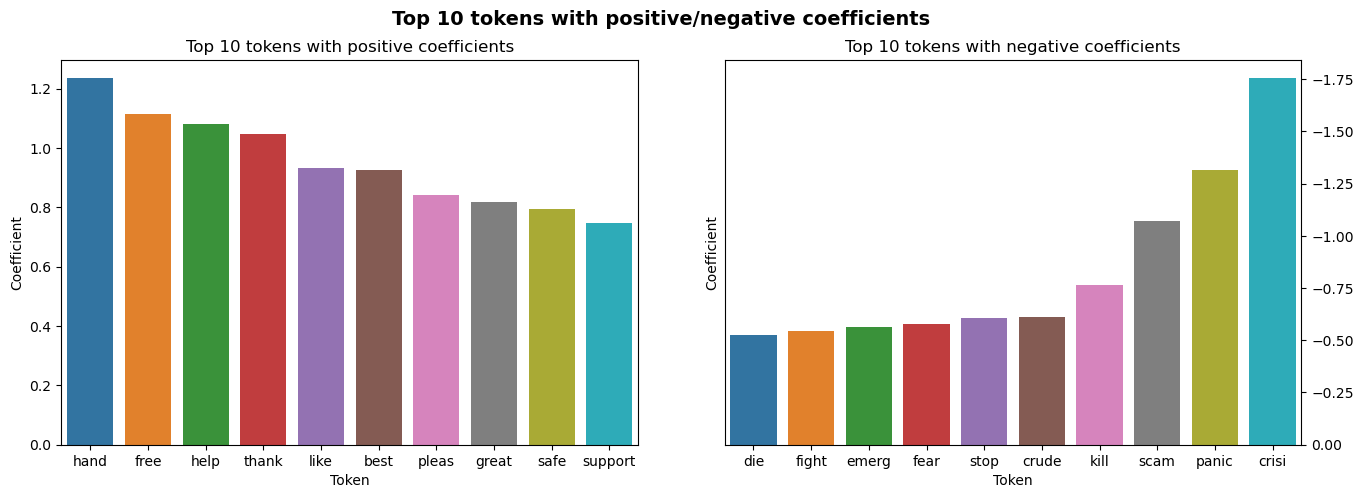

In [462]:
model_df = pd.DataFrame({
    "x": cv_df.get_feature_names_out(),
    "y": model_cv_df.coef_[0]
})
model_df.sort_values(by="y", inplace=True, ascending=False)
top_ten = model_df.head(10).copy()
last_ten = model_df.tail(10).copy()

fig = plt.figure(figsize=(16, 5))
fig.suptitle("Top 10 tokens with positive/negative coefficients", fontsize=14, fontweight="demibold")
gs = fig.add_gridspec(nrows=1,
                      ncols=2,
                      width_ratios=(1, 1),
                      wspace=0.15,
                      hspace=0.05)
ax_pos = fig.add_subplot(gs[0, 0])
ax_neg = fig.add_subplot(gs[0, 1])

sns.barplot(x=top_ten.x, y=top_ten.y, ax=ax_pos)
ax_pos.set_title("Top 10 tokens with positive coefficients")
ax_pos.set_xlabel("Token")
ax_pos.set_ylabel("Coefficient")
sns.barplot(x=last_ten.x, y=last_ten.y, ax=ax_neg)
ax_neg.set_title("Top 10 tokens with negative coefficients")
ax_neg.set_xlabel("Token")
ax_neg.set_ylabel("Coefficient")
ax_neg.yaxis.tick_right()
ax_neg.invert_yaxis()
plt.show()

**Ответ:** из графиков видно, что слова best, free, super, enjoy и т.д., выражающие положительные с точки зрения человека вещи, имеют бОльшие положительные коэффициенты (следовательно, модель с большей вероятностью выдаст 1 на таком тексте), и наоборот, слова worst, danger, kill, fail, scam и т.д., выражающие негативные с точки зрения человека вещи, имеют бОльшие по модулю отрицательные коэффициенты, и модель с большей вероятностью выдаст 0 на таком тексте

## Задание 7 Другие признаки (1.5 балла)

Мы были сконцентрированы на работе с текстами твиттов и не использовали другие признаки - имена пользователя, дату и местоположение

Изучите признаки UserName и ScreenName. полезны ли они? Если полезны, то закодируйте их, добавьте к матрице с отскалированными признаками, обучите логистическую регрессию, замерьте качество.

Судя по датасету, UserName и ScreenName - случайно назначенные числа относительно текста твита, однако между ними есть связь:

In [463]:
pd.concat((df.head(2), df.tail(2)), axis=0)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,True
1,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,True
33442,44953,89905,Unknown,14-04-2020,You know itÃÂs getting tough when @KameronWi...,True
33443,44955,89907,i love you so much || he/him,14-04-2020,@TartiiCat Well new/used Rift S are going for ...,False


In [464]:
assert all(df.UserName - df.ScreenName == -44952)

In [465]:
df[["UserName", "ScreenName", "Sentiment"]].corr().style.background_gradient(cmap='coolwarm')

,UserName,ScreenName,Sentiment
UserName,1.000000,1.000000,0.050988
ScreenName,1.000000,1.000000,0.050988
Sentiment,0.050988,0.050988,1.000000


Таким образом, даже если UserName или ScreenName и будет добавлен к матрице с признаками, добавлять другой признак не будет иметь смысла

In [466]:
X_train_with_names = np.concatenate((
    X_train_cv_df.toarray(),
    StandardScaler().fit_transform(train[["UserName", "ScreenName"]].to_numpy())
), axis=1)

In [467]:
X_train_with_names

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.92443746,  0.92443746],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         1.39925151,  1.39925151],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         1.26710153,  1.26710153],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         1.42786998,  1.42786998],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.46351178,  0.46351178],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
        -1.43860628, -1.43860628]])

In [468]:
X_test_with_names = np.concatenate((
    X_test_cv_df.toarray(),
    StandardScaler().fit_transform(test[["UserName", "ScreenName"]].to_numpy())
), axis=1)

In [469]:
X_test_with_names

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         1.18178408,  1.18178408],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.31118276,  0.31118276],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         1.55731941,  1.55731941],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
        -0.54045213, -0.54045213],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.44394778,  0.44394778],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.66370549,  0.66370549]])

In [470]:
model_cv_df = LogisticRegression(random_state=random_state).fit(X_train_with_names, y_train)

In [471]:
print(f"Accuracy on train when names are added:\n{accuracy_score(y_train, model_cv_df.predict(X_train_with_names))}")

Accuracy on train when names are added:
0.9418197351559163


In [472]:
print(f"Accuracy on test when names are added:\n{accuracy_score(y_test, model_cv_df.predict(X_test_with_names))}")

Accuracy on test when names are added:
0.8463225034881403


**Ответ:** при добавлении имён, представленных псевдо случайно сгенерированными числами, качество не улучшается

Изучите признак TweetAt в обучающей выборке: преобразуйте его к типу datetime и нарисуйте его гистограмму с разделением по цвету на оспнове целевой переменной. Полезен ли он? Если полезен, то закодируйте его, добавьте к матрице с отскалированными признаками, обучите логистическую регрессию, замерьте качество.

In [473]:
train.TweetAt

25621    06-04-2020
30135    10-04-2020
28899    09-04-2020
5989     19-03-2020
4367     18-03-2020
            ...    
20757    31-03-2020
32103    13-04-2020
30403    10-04-2020
21243    01-04-2020
2732     18-03-2020
Name: TweetAt, Length: 23410, dtype: object

In [474]:
train.TweetAt = pd.to_datetime(train.TweetAt, format="%d-%m-%Y")
test.TweetAt = pd.to_datetime(test.TweetAt, format="%d-%m-%Y")
train.TweetAt

25621   2020-04-06
30135   2020-04-10
28899   2020-04-09
5989    2020-03-19
4367    2020-03-18
           ...    
20757   2020-03-31
32103   2020-04-13
30403   2020-04-10
21243   2020-04-01
2732    2020-03-18
Name: TweetAt, Length: 23410, dtype: datetime64[ns]

e:\Programs\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
e:\Programs\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
e:\Programs\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


<Axes: xlabel='TweetAt', ylabel='Count'>

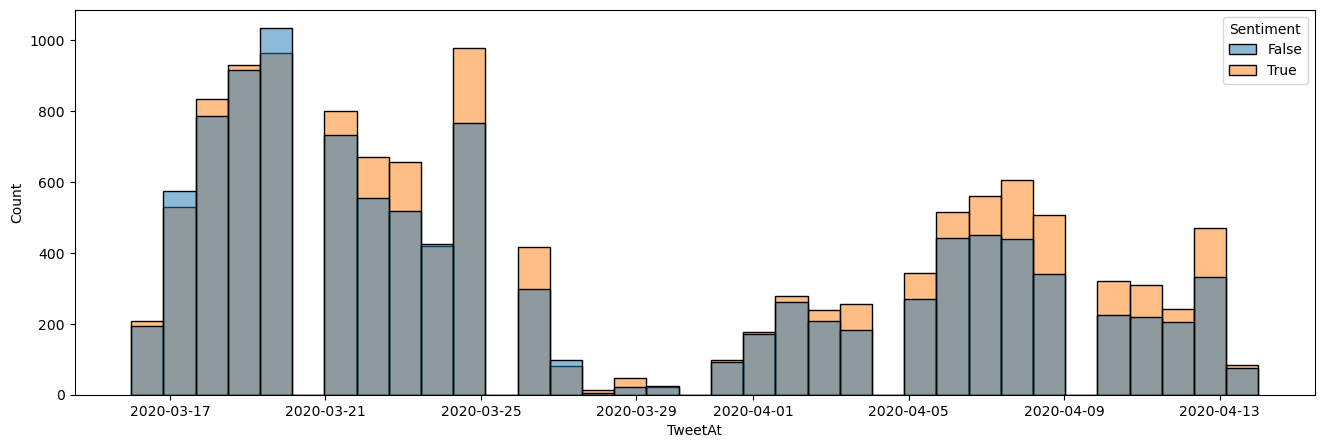

In [475]:
fig, ax_tweet_time_hist = plt.subplots(figsize=(16, 5))
sns.histplot(data=train,
             x="TweetAt",
             hue="Sentiment",
             bins=35,
             ax=ax_tweet_time_hist)

Выделим 3 интервала: [17.03.2020; 20.03.2020], [21.03.2022; 26.03.2020] и [05.04.2020; 13.04.2020], а также день года, количество прошедших секунд с начала Unix эпохи, а также их синус и косинус:

In [476]:
def get_time_info(df: pd.DataFrame):
    new_df = pd.DataFrame({
        # https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#from-timestamps-to-epoch
        "UnixTimeScaled": (df.TweetAt - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')
    }, index=df.index)
    new_df["UnixTimeCos"] = np.cos(new_df["UnixTimeScaled"])
    new_df["UnixTimeSin"] = np.sin(new_df["UnixTimeScaled"])
    new_df["UnixTimeScaled"] = StandardScaler().fit_transform(new_df["UnixTimeScaled"].to_numpy().reshape(-1, 1))

    boundaries = (
        (pd.Timestamp(year=2020, month=3, day=17), pd.Timestamp(year=2020, month=3, day=20)),
        (pd.Timestamp(year=2020, month=4, day=5), pd.Timestamp(year=2020, month=4, day=9)),
        (pd.Timestamp(year=2020, month=4, day=10), pd.Timestamp(year=2020, month=4, day=13)),
    )
    from itertools import pairwise
    for (l_b1, r_b1), (l_b2, r_b2) in pairwise(boundaries):
        assert l_b1 <= r_b1 < l_b2 < r_b2
    for i, (l_b, r_b) in enumerate(boundaries):
        new_df[f"Interval_{i+1}"] = df.TweetAt.between(l_b, r_b)
    new_df["DayOfYear"] = df.TweetAt.apply(lambda t: t.day_of_year)
    return new_df


In [477]:
train_time_info_df = get_time_info(train)
train_time_info_df

,UnixTimeScaled,UnixTimeCos,UnixTimeSin,Interval_1,Interval_2,Interval_3,DayOfYear
25621,1.039195,0.694918,-0.719089,False,True,False,97
30135,1.485504,0.429257,-0.903183,False,False,True,101
28899,1.373927,0.501065,-0.865410,False,True,False,100
5989,-0.969198,0.790989,0.611830,True,False,False,79
4367,-1.080775,0.738785,0.673941,True,False,False,78
...,...,...,...,...,...,...,...
20757,0.369730,0.950630,-0.310326,False,False,False,91
32103,1.820236,0.198858,-0.980028,False,False,True,104
30403,1.485504,0.429257,-0.903183,False,False,True,101
21243,0.481308,0.922343,-0.386373,False,False,False,92


In [478]:
test_time_info_df = get_time_info(test)
test_time_info_df

,UnixTimeScaled,UnixTimeCos,UnixTimeSin,Interval_1,Interval_2,Interval_3,DayOfYear
28168,1.248710,0.569574,-0.821940,False,True,False,99
19874,-0.201238,0.995929,0.090136,False,False,False,86
31702,1.694848,0.277654,-0.960681,False,False,True,103
5110,-0.981979,0.790989,0.611830,True,False,False,79
30081,1.471779,0.429257,-0.903183,False,False,True,101
...,...,...,...,...,...,...,...
5847,-0.981979,0.790989,0.611830,True,False,False,79
3220,-1.093514,0.738785,0.673941,True,False,False,78
11637,-0.758910,0.879468,0.475959,False,False,False,81
21149,0.467969,0.922343,-0.386373,False,False,False,92


In [484]:
X_train_with_time = np.concatenate((
    X_train_cv_df.toarray(),
    train_time_info_df.to_numpy(),
), axis=1)
X_train_with_time

MemoryError: Unable to allocate 662. MiB for an array with shape (23410, 3707) and data type object

In [ ]:
X_train_with_time.shape

(23410, 3707)

In [ ]:
X_test_with_time = np.concatenate((
    X_test_cv_df.toarray(),
    test_time_info_df.to_numpy(),
), axis=1)
X_test_with_time

array([[0.0, 0.0, 0.0, ..., True, False, 99],
       [0.0, 0.0, 0.0, ..., False, False, 86],
       [0.0, 0.0, 0.0, ..., False, True, 103],
       ...,
       [0.0, 0.0, 0.0, ..., False, False, 81],
       [0.0, 0.0, 0.0, ..., False, False, 92],
       [0.0, 0.0, 0.0, ..., False, False, 95]], dtype=object)

In [ ]:
model_cv_df = LogisticRegression(random_state=random_state, max_iter=500, C=0.5).fit(X_train_with_time, y_train)
print(f"Accuracy on train when tweet post time info is added:\n{accuracy_score(y_train, model_cv_df.predict(X_train_with_time))}")
print(f"Accuracy on test when tweet post time info is added:\n{accuracy_score(y_test, model_cv_df.predict(X_test_with_time))}")

Accuracy on train when tweet post time info is added:
0.9416061512174284
Accuracy on test when tweet post time info is added:
0.8462228423360574


**Ответ:** # -- YOUR ANSWER HERE --



Поработайте с признаком Location в обучающей выборке. Сколько уникальных значений?

In [ ]:
train.Location.nunique()

7949

Постройте гистограмму топ-10 по популярности местоположений (исключая Unknown)

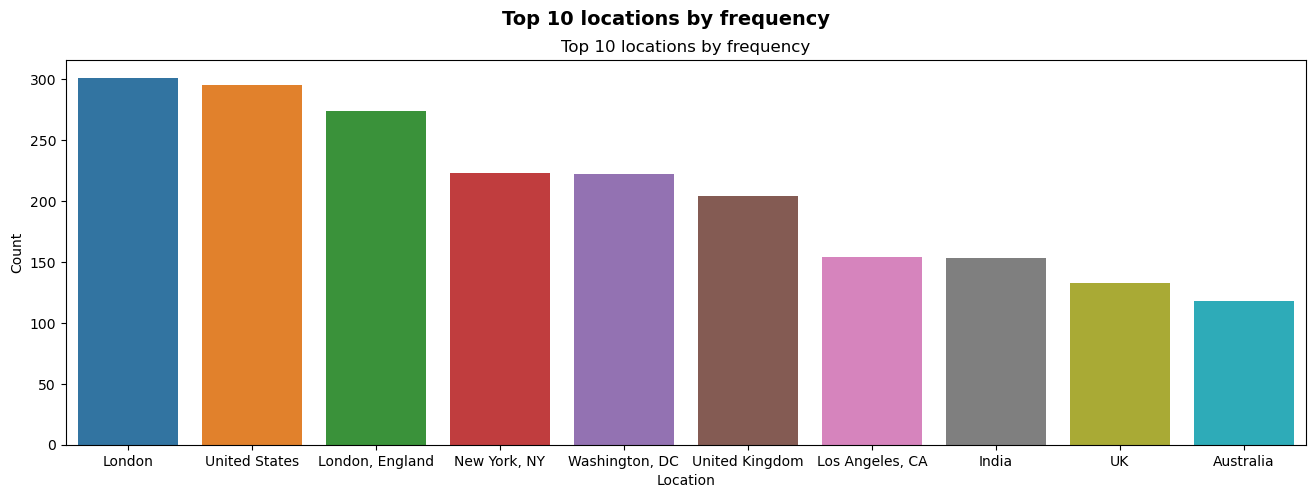

In [ ]:
loc_vc = train.Location.value_counts()
loc_df = pd.DataFrame({
    "Location": loc_vc.index,
    "Count": loc_vc.values
})
loc_df.set_index(keys="Location", drop=True, inplace=True)
loc_df.drop(labels="Unknown", axis=0, inplace=True)
loc_df.sort_values(by="Count", inplace=True, ascending=False)
top_ten = loc_df.head(10)

fig, ax = plt.subplots(figsize=(16, 5))
fig.suptitle("Top 10 locations by frequency", fontsize=14, fontweight="demibold")
sns.barplot(x=top_ten.index, y=top_ten.Count, ax=ax)
ax.set_title("Top 10 locations by frequency")
ax.set_xlabel("Location")
ax.set_ylabel("Count")
plt.show()

Видно, что многие местоположения включают в себя более точное название места, чем другие (Например, у некоторых стоит London, UK; а у некоторых просто UK или United Kingdom).

Создайте новый признак WiderLocation, который содержит самое широкое местоположение (например, из London, UK должно получиться UK). Сколько уникальных категорий теперь? Постройте аналогичную гистограмму.

In [ ]:
def coder(loc: str):
    loc = loc.lower()
    if "london" in loc:
        return "uk"
    if "new york" in loc:
        return "ny"
    if "united" in loc:
        return "uk" if "kingdom" in loc else "us"
    if loc == "usa":
        return "us"
    if "ca" in loc:
        return "ca"
    if "dc" in loc:
        return "dc"
    if "ontario" in loc:
        return "ontario"
    if "new delhi" in loc:
        return "new delhi"
    return loc

train["WiderLocation"] = train.Location.apply(coder)

In [ ]:
train["WiderLocation"].nunique()

6365

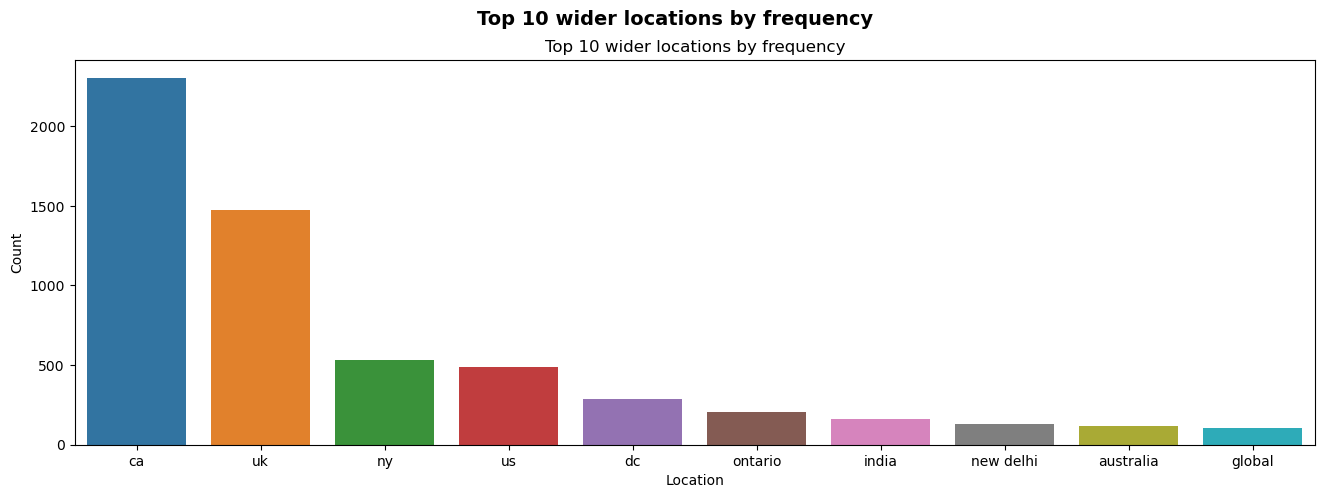

In [ ]:
loc_vc = train.WiderLocation.value_counts()
loc_df = pd.DataFrame({
    "Location": loc_vc.index,
    "Count": loc_vc.values
})
loc_df.set_index(keys="Location", drop=True, inplace=True)
loc_df.drop(labels="unknown", axis=0, inplace=True)
loc_df.sort_values(by="Count", inplace=True, ascending=False)
top_ten = loc_df.head(10)

fig, ax = plt.subplots(figsize=(16, 5))
fig.suptitle("Top 10 wider locations by frequency", fontsize=14, fontweight="demibold")
sns.barplot(x=top_ten.index, y=top_ten.Count, ax=ax)
ax.set_title("Top 10 wider locations by frequency")
ax.set_xlabel("Location")
ax.set_ylabel("Count")
plt.show()

Закодируйте признак WiderLocation с помощью OHE таким образом, чтобы создались только столбцы для местоположений, которые встречаются более одного раза. Сколько таких значений?


In [ ]:
mask = ~train.WiderLocation.copy().isin(loc_df[loc_df.Count > 1].index)
train[mask].WiderLocation = np.nan

C:\Users\Владимир\AppData\Local\Temp\ipykernel_10248\1601594088.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[~train.WiderLocation.isin(loc_df[loc_df.Count > 1].index)].WiderLocation = np.nan


In [ ]:
pd.get_dummies(train)

Добавьте этот признак к матрице отскалированных текстовых признаков, обучите логистическую регрессию, замерьте качество. Как оно изменилось? Оказался ли признак полезным?


*Подсказка:* используйте параметр `categories` в энкодере.

In [ ]:
# -- YOUR CODE HERE --

**Ответ:** # -- YOUR ANSWER HERE --

## Задание 8 Хорошее качество (Бонус 1 балл)

Добейтесь accuracy=0.9 на тестовой выборке (можно сменить токенайзер, векторайзер, модель и т.д.)

In [ ]:
# -- YOUR CODE HERE --